# Case study of uniaxial tensile tests

This is an example of how to use Paramaterial to process a dataset of uniaxial tensile test measurements.
The data should be formatted as a set of csv files containing measurements for each test, and a single excel spreadsheet containing the metadata for the dataset.
There should be a single row in the excel spreadsheet for each csv file.

The analysis takes 4 stages:
- Data preparation
- Data processing
- Model fitting
- Test report generation

## Modelling
- Make representative curves
- Fit models
- Fit equations for model parameters

In [1]:
from typing import Callable

import numpy as np
from matplotlib import pyplot as plt

import paramaterial as pam
from paramaterial import ModelSet
from paramaterial.models import ramberg
from paramaterial.plug import DataSet, DataItem

Start with processed data.

In [2]:
processed_ds = DataSet('info/02 processed info.xlsx', 'data/02 processed data')

Setup plotting.

In [3]:
styler = pam.plotting.Styler(
    color_by='temperature', cmap='plasma', color_by_label='(°C)', color_norm=plt.Normalize(20, 320),
    plot_kwargs=dict(grid=True))
styler.style_to(processed_ds.sort_by(['temperature', 'lot']))


def ds_plot(ds: DataSet, **kwargs):
    return pam.plotting.dataset_plot(ds, styler=styler, **kwargs)


subplot_cfg = dict(
    shape=(3, 3), sharex='all', sharey='all', hspace=0.2,
    rows_by='lot', row_vals=[[a] for a in 'ABCDEFGHI'],
    cols_by='lot', col_vals=[[a] for a in 'ABCDEFGHI'],
    plot_titles=[f'Lot {a}' for a in 'ABCDEFGHI']
)


def ds_subplots(ds: DataSet, **kwargs):
    return pam.plotting.dataset_subplots(ds=ds, styler=styler, plot_legend=False, **subplot_cfg, **kwargs)


def subplot_wrapper(ds: DataSet, plot_func: Callable[[DataItem], DataItem], **plot_func_kwargs):
    return pam.plotting.subplot_wrapper(ds=ds, plot_func=plot_func, **subplot_cfg, **plot_func_kwargs)


stress_strain_labels = dict(x='Strain', y='Stress_MPa', ylabel='Stress (MPa)')

### Make representative curves
There is clear temperature dependence.
We are also interested in differences between lots.
We therefore make representative curves:
- Grouped by temperature
- Grouped by temperature and lot

Make representative curves grouped by temperature.

In [4]:
pam.make_representative_data(ds=processed_ds,
                                        data_dir='data/03 temp repr data', info_path='info/03 temp repr info.xlsx',
                                        repr_col='Stress_MPa', repr_by_cols=['temperature'], group_info_cols=['E', 'UPL_1'],
                                        interp_by='Strain', interp_end='min_of_maxes', interp_res=1000)
temp_repr_ds = DataSet('info/03 temp repr info.xlsx', 'data/03 temp repr data', test_id_key='repr id')
temp_repr_ds

DataSet with 6 DataItems containing
	info: columns -> repr id, temperature, nr averaged, mean_E, mean_UPL_1
	data: len = 1000, columns -> interp_Strain, mean_Stress_MPa, std_Stress_MPa, up_std_Stress_MPa, down_std_Stress_MPa, up_2std_Stress_MPa, down_2std_Stress_MPa, up_3std_Stress_MPa, down_3std_Stress_MPa, min_Stress_MPa, max_Stress_MPa, q1_Stress_MPa, q3_Stress_MPa

Plot representative curves grouped by temperature.

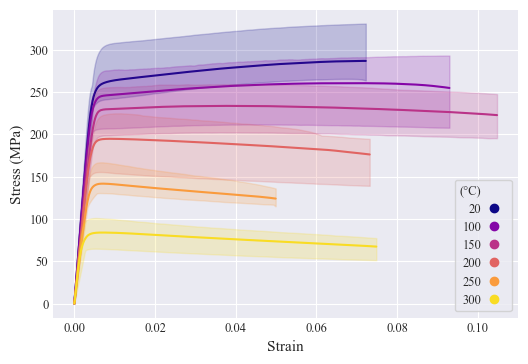

In [5]:
repr_stress_strain_labels = dict(x='interp_Strain', y='mean_Stress_MPa',
                                 fill_between=('min_Stress_MPa', 'max_Stress_MPa'),
                                 xlabel='Strain', ylabel='Stress (MPa)')  # todo: make error bar plots
ds_plot(temp_repr_ds, **repr_stress_strain_labels);

Make representative curves grouped by temperature and lot.

Plot representative curves grouped by temperature and lot.

### Fit models
- Trim to 0.01 Strain
- Fit models to temperature grouped curves
- Fit models to temperature and lot grouped curves

In [6]:
def trim_for_fitting(di):
    di.data = di.data[di.data['interp_Strain'] <= 0.01]
    return di


temp_repr_ds = temp_repr_ds.apply(trim_for_fitting)

### Fit models to small-strain representative data

In [7]:
# ms = ModelSet(ramberg, ['E', 's_y', 'C', 'n'], bounds=[(35e3, 90e3), (1., 280.), (30, 220.), (0.01, 0.8)], scipy_func='basinhopping')
ms = ModelSet(ramberg, param_names = ['C', 'n'], var_names=['mean_E', 'mean_UPL_1'],
              bounds=[(30, 220.), (0.01, 0.8)], scipy_func='basinhopping')
ms.fit_to(temp_repr_ds, 'interp_Strain', 'mean_Stress_MPa', sample_size=40)
temp_ramberg_ds = ms.predict()

In [8]:
print(temp_ramberg_ds.info_table)
ms.params_table

        repr id  temperature  nr averaged        mean_E  mean_UPL_1  \
0  repr_id_0001           20           19  59652.660025  163.246165   
1  repr_id_0002          100           19  59855.779245  145.231324   
2  repr_id_0003          150           12  49741.584567  130.886697   
3  repr_id_0004          200           19  48391.353424  134.834703   
4  repr_id_0005          250           12  40860.567968   86.387217   
5  repr_id_0006          300           19  43041.850174   56.335229   

            C         n            model_id model_name  x_min     x_max  \
0  196.388923  0.122155  model_repr_id_0001    ramberg    0.0  0.009978   
1  196.103023  0.118636  model_repr_id_0002    ramberg    0.0  0.009956   
2  175.273355  0.100491  model_repr_id_0003    ramberg    0.0  0.009962   
3  126.078838  0.133782  model_repr_id_0004    ramberg    0.0  0.009965   
4   98.293530  0.104508  model_repr_id_0005    ramberg    0.0  0.009990   
5   69.563087  0.175723  model_repr_id_0006    rambe

,model_id,C,n
0,model_repr_id_0001,196.388923,0.122155
0,model_repr_id_0002,196.103023,0.118636
0,model_repr_id_0003,175.273355,0.100491
0,model_repr_id_0004,126.078838,0.133782
0,model_repr_id_0005,98.293530,0.104508
0,model_repr_id_0006,69.563087,0.175723


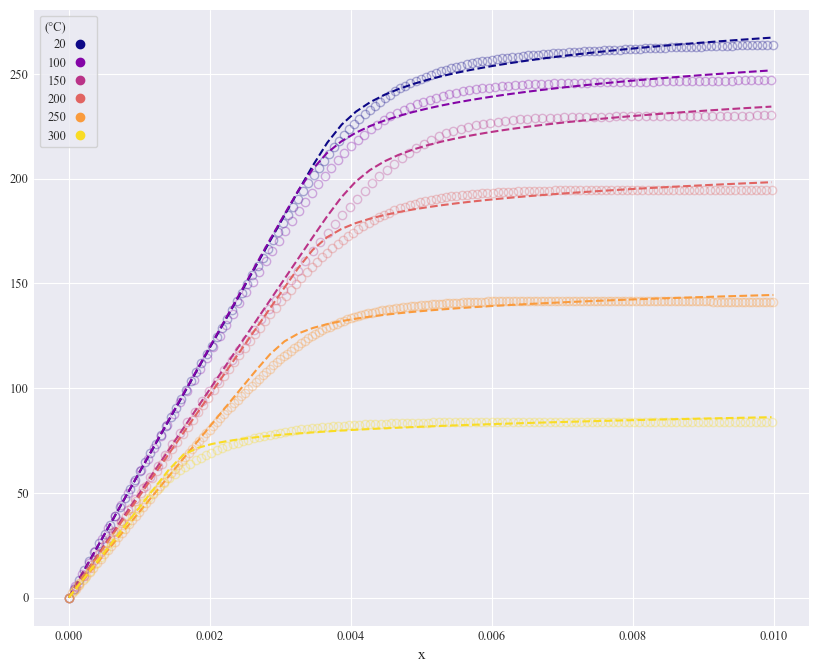

In [9]:
ax = ds_plot(temp_repr_ds, x='interp_Strain', y='mean_Stress_MPa', alpha=0.3, lw=0, marker='o', mfc='none',figsize=(10,8))
ds_plot(temp_ramberg_ds, x='x', y='y', ls='--', ax=ax);